# Generative Adversarial Network (GAN)

In [1]:
# Import TensorFlow
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 2.x selected.
2.1.0


## Libraries

In [0]:
# Work with images
import imageio

# Visualization
import matplotlib.pyplot as plt

# Operations
import numpy as np

# Files and Folders
import os

# Image Processing
import PIL

# Neural Network Layers
from tensorflow.keras.layers import Dense, BatchNormalization, Conv2DTranspose, LeakyReLU, Reshape, Conv2D, Flatten, Dropout

# Time
import time

# Display data
from IPython import display

## Load the data

In [3]:
# Download the dataset MNIST (only the training data)
(train_images, train_labels), (_,_) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


## Prepare the data

In [0]:
# Reshape our data and convert to size 28 by 28
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

# Rescale our data to be between -1 and 1
train_images = (train_images - 255.0 / 2.0) / (255.0 / 2.0)

In [0]:
# Number of samples (60000)
BUFFER_SIZE = len(train_images)

# Batch size
BATCH_SIZE = 256

# Structure the data, mixing and packaging them into batches
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create our Generator Model


In [0]:
# Create our Generator Model
model_generator = tf.keras.Sequential()

# INPUT LAYER
# Random array of 100
model_generator.add(Dense(7*7*256, use_bias = False, input_shape = (100, )))

# Minimize the weights of the input layer
model_generator.add(BatchNormalization())

# Activation Function (applies to the input layer)
model_generator.add(LeakyReLU())

# Reshapes the data
model_generator.add(Reshape((7, 7, 256)))

# Convolution of our data
model_generator.add(Conv2DTranspose(128,  # Neurons
                                    (5, 5),  # Kernel
                                    strides = (1, 1),  # Using the kernel 1 by 1
                                    padding = 'same',
                                    use_bias = False))
model_generator.add(BatchNormalization())
model_generator.add(LeakyReLU())

model_generator.add(Conv2DTranspose(64,
                                    (5, 5),
                                    strides = (2, 2),
                                    padding = 'same',
                                    use_bias = False))
model_generator.add(BatchNormalization())
model_generator.add(LeakyReLU())

# OUTPUT LAYER
model_generator.add(Conv2DTranspose(1,
                                    (5, 5),
                                    strides = (2, 2),
                                    padding = 'same',
                                    use_bias = False,
                                    activation = 'tanh'))  # -1 to 1

### Example of our Generator Model

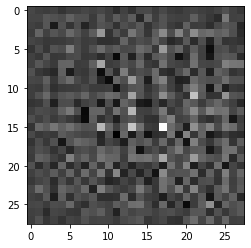

In [7]:
# Random vector
noise = tf.random.normal([1, 100])

# Try out the random data (not training)
noise_image = model_generator(noise, training = False)

# Visualize (4 dimensions)
plt.imshow(noise_image[0, :, :, 0], cmap = 'gray')

## Create our Discriminator Model
Size 28x28<br>
0-1

In [0]:
# Create our Discriminator Model
model_discriminator = tf.keras.Sequential()

# INPUT LAYER
# Convolution
model_discriminator.add(Conv2D(64, 
                               (5, 5), 
                               strides = (2, 2), 
                               padding = 'same',
                               input_shape = [28, 28, 1]))

# Activation Function
model_discriminator.add(LeakyReLU())

# 30% dropout of neurons
model_discriminator.add(Dropout(0.3))

# Convolution
model_discriminator.add(Conv2D(128, 
                               (5, 5), 
                               strides = (2, 2), 
                               padding = 'same'))
model_discriminator.add(LeakyReLU())
model_discriminator.add(Dropout(0.3))

# Flatten the data
model_discriminator.add(Flatten())

# OUTPUT LAYER
model_discriminator.add(Dense(1))

### Test our Model
== Not trained yet ==

In [9]:
# Test the model
decision = model_discriminator(noise_image, training = False)

print(decision)

tf.Tensor([[0.00166217]], shape=(1, 1), dtype=float32)


## Prepare our Models

In [0]:
# Define the function which allows us to calculate the cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)          # Probabilities

In [0]:
# Create our Discriminator Error function (sum of what is right being real, and what is right being false)
# Goal: minimize the error
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

# Create our Generator Error function (we take into account the fake classification error)
# Goal: maximize the error
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

### Model Optimizers

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(lr = 0.0001)                     # Learning rate

discriminator_optimizer = tf.keras.optimizers.Adam(lr = 0.0001)

### Model Checkpoints

In [0]:
# Checkpoints during our Training to save our progress
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')

checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = model_generator,
                                 discriminator = model_discriminator)

### Model Settings

In [0]:
epochs = 50

noise_dimension = 100

# Images we create for each iteration
num_examples_generated = 16

seed = tf.random.normal([num_examples_generated, noise_dimension])

### Compile Function

In [0]:
# Compile the following function
@tf.function

def train_step(image):
  noise = tf.random.normal([BATCH_SIZE, noise_dimension])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    # Generate fake images
    images_generated = model_generator(noise, training = True)

    # Compare real with fake images
    real_output = model_discriminator(image, training = True)
    fake_output = model_discriminator(images_generated, training = True)

    # Calculate the Errors
    loss_generator = generator_loss(fake_output)
    loss_discriminator = discriminator_loss(real_output, fake_output)

    # Combine, calculate new Gradients and Weights (taking into account the loss)
    gradient_generator = gen_tape.gradient(loss_generator, model_generator.trainable_variables)
    gradient_discriminator = disc_tape.gradient(loss_discriminator, model_discriminator.trainable_variables)

    # Apply the new Gradients on all variables
    generator_optimizer.apply_gradients(zip(gradient_generator, model_generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradient_discriminator, model_discriminator.trainable_variables))

### Train Function

In [0]:
# Evaluate our results during our epochs
def train(dataset, epochs):
  for epoch in range(epochs):

    # Timestamp
    start = time.time()

    # 256 images
    for image_batch in dataset:
      train_step(image_batch)

    # Display the images
    display.clear_output(wait = True)

    # Save new images
    generate_and_save_images(model_generator, epoch + 1, seed)

    # Checkpoints
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    print('Time to calculate the epoch', epoch + 1, 'was: ', time.time() - start, 'seconds')
  display.clear_output(wait = True)
  generate_and_save_images(model_generator, epochs, seed)

# Save and display function of our newly generated images
def generate_and_save_images(model, epoch, test_input):
  prediction = model(test_input, training = False)
  fig = plt.figure(figsize = (4, 4))

  for i in range(prediction.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(prediction[i, :, :, 0] * (255.0 / 2.0) + (255.0 / 2.0), cmap = 'gray')
    plt.axis('off')
    plt.savefig('image_epoch_{:4d}.png'.format(epoch))
  plt.show()

## Train our Model

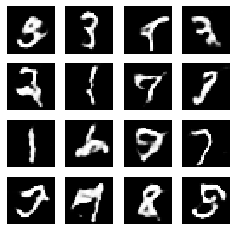

In [17]:
# Train our Generative Adversarial Network (GAN)
train(train_dataset, epochs)